# Getting Started with Hankel

## Usage and Description

### Setup

This implementation is set up to allow efficient calculation of
multiple functions $f(x)$. To do this, the format is
class-based, with the main object taking as arguments the order of the
Bessel function, and the number and size of the
integration steps (see [Limitations](#Limitations) for discussion
about how to choose these key parameters).

For any general integration or transform of a function, we perform the
following setup:

In [1]:
from hankel import HankelTransform     # Import the basic class

ht = HankelTransform(nu= 0,            # The order of the bessel function
                     N = 120,          # Number of steps in the integration
                     h = 0.03)         # Proxy for "size" of steps in integration

Alternatively, each of the parameters has defaults, so you needn't
pass any. The order of the bessel function will be
defined by the problem at hand, while the other arguments typically
require some exploration to set them optimally.


### Integration

A Hankel-type integral is the integral

$$ \int_0^\infty f(x) J_\nu(x) dx. $$

Having set up our transform with ``nu = 0``, we may wish to perform
this integral for $f(x) = 1$. To do this, we do the
following:

In [3]:
# Create a function which is identically 1.
f = lambda x : 1   
ht.integrate(f)

(1.0000000000003486, -9.8381428368537518e-15)

The correct answer is 1, so we have done quite well. The second
element of the returned result is an estimate of the
error (it is the last term in the summation). The error estimate can
be omitted using the argument ``ret_err=False``.

We may now wish to integrate a different function, say $x/(x^2 + 1)$.
We can do this directly with the same object,
without re-instantiating (avoiding unnecessary recalculation):

In [4]:
f = lambda x : x/(x**2 + 1)
ht.integrate(f)

(0.42098875721567186, -2.6150757700135774e-17)

The analytic answer here is $K_0(1) = 0.4210$. The accuracy could be
increased by creating ``ht`` with a higher number
of steps ``N``, and lower stepsize ``h`` (see [Limitations](#Limitations)).

### Transforms

The Hankel transform is defined as

$$ F_\nu(k) = \int_0^\infty f(r) J_\nu(kr) r dr. $$

We see that the Hankel-type integral is the Hankel transform of
$f(r)/r$ with $k=1$. To perform this more general
transform, we must supply the $k$ values. Again, let's use our
previous function, $x/(x^2 + 1)$. 

First we'll import some libraries to help us visualise:

In [7]:
import numpy as np              # Import numpy
import matplotlib.pyplot as plt
%matplotlib inline

Now do the transform,

In [ ]:
k = np.logspace(-1,1,50)        # Create a log-spaced array of k from 0.1 to 10.
Fk = ht.transform(f,k,ret_err=False) # Return the transform of f at k.

and finally plot it:

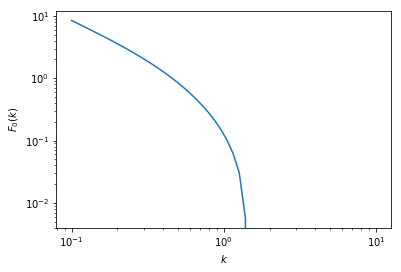

In [11]:
plt.plot(k,Fk)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$F_0(k)$")
plt.xlabel(r"$k$")
plt.show()

### Fourier Transforms

One of the most common applications of the Hankel transform is to
solve the [radially symmetric n-dimensional Fourier
  transform](https://en.wikipedia.org/wiki/Hankel_transform#Relation_to_the_Fourier_transform_.28radially_symmetric_case_in_n-dimensions.29):

$$ F(k) = \frac{(2\pi)^{n/2}}{k^{n/2-1}} \int_0^\infty r^{n/2-1} f(r) J_{n/2-1}(kr)r dr.$$

We provide a specific class to do this transform, which takes into
account the various normalisations and substitutions
required, and also provides the inverse transform. The procedure is
similar to the basic ``HankelTransform``, but we
provide the number of dimensions, rather than the Bessel order
directly. 

Say we wish to find the Fourier transform of
$f(r) = 1/r$ in 3 dimensions:

In [12]:
# Import the Symmetric Fourier Transform class
from hankel import SymmetricFourierTransform

# Create our transform object, similar to HankelTransform,
# but with ndim specified instead of nu.
ft = SymmetricFourierTransform(ndim=3, N = 200, h = 0.03)

# Create our kernel function to be transformed.
f = lambda r : 1./r

# Perform the transform
Fk = ft.transform(f,k, ret_err=False)

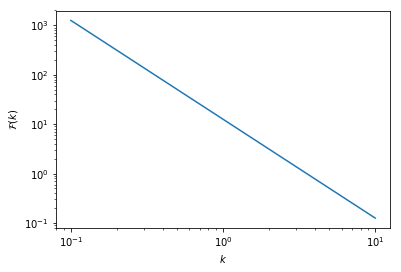

In [13]:
plt.plot(k,Fk)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\mathcal{F}(k)$")
plt.xlabel(r"$k$")
plt.show()

To do the inverse transformation (which is different by a
normalisation constant), merely supply ``inverse=True`` to
the ``.transform()`` method.

## Limitations

### Efficiency

An implementation-specific limitation is that the method is not
perfectly efficient in all cases. Care has been taken
to make it efficient in the general sense. However, for specific
orders and functions, simplifications may be made
which reduce the number of trigonometric functions evaluated. For
instance, for a zeroth-order spherical transform,
the weights are analytically always identically 1.

### Lower-Bound Convergence

In terms of limitations of the method, they are very dependent on the
form of the function chosen. Notably, functions
which tend to infinity at x=0 will be poorly approximated in this
method, and will be highly dependent on the step-size
parameter, as the information at low-x will be lost between 0 and the
first step. As an example consider the simple
function $f(x) = 1/\sqrt{x}$ with a 1/2 order bessel function. The
  total integrand tends to 1 at $x=0$, rather than 0:

In [14]:
f = lambda x: 1/np.sqrt(x)
h = HankelTransform(0.5,120,0.03)
h.integrate(f)

(1.2336282257874065, -2.864861354876958e-16)

The true answer is $\sqrt{\pi/2}$, which is a difference of about 1.6%. Modifying the step size and number of steps to gain accuracy we find:

In [15]:
h = HankelTransform(0.5,700,0.001)
h.integrate(f)

(1.2523045155005623, -0.0012281146007915768)

This has much better than percent accuracy, but uses 5 times the
  amount of steps. The key here is the reduction of h
to "get inside" the low-x information. This limitation is amplified
  for cases where the function really does tend to
infinity at $x=0$, rather than a finite positive number, such as $f(x)= 1/x$. Clearly the integral becomes non-convergent for some $f(x)$, in which case the numerical approximation can never  be correct.

### Upper-Bound Convergence

If the function $f(x)$ is monotonically increasing, or at least very slowly decreasing, then higher and higher zeros of the Bessel function will be required to capture the convergence.
Often, it will be the case that if this is so, the amplitude of the function is low at low $x$, so that the step-size ``h`` can be increased to facilitate this. Otherwise, the number of steps ``N`` can be increased.

For example, the 1/2-order integral supports functions that are increasing up to $f(x) = x^{0.5}$ and no more (otherwise they diverge). Let's use $f(x) = x^{0.4}$ as an example of a slowly converging function, and use our "hi-res" setup from the previous section:

In [16]:
h = HankelTransform(0.5,700,0.001)
f = lambda x : x**0.4
h.integrate(f)

(0.5367827792529053, -1.0590954621251101)

The analytic result is 0.8421449 -- very far from our result. Note that in this case, the error estimate itself is a good indication that we haven't reached convergence. We could try
  increasing ``N``:

In [17]:
h = HankelTransform(0.5,10000,0.001)
h.integrate(f,ret_err=False)/0.8421449 -1

hankel/hankel.py:72: RuntimeWarning: overflow encountered in sinh
  a = (np.pi*t*np.cosh(t) + np.sinh(np.pi*np.sinh(t)))/(1.0 + np.cosh(np.pi*np.sinh(t)))
hankel/hankel.py:72: RuntimeWarning: overflow encountered in cosh
  a = (np.pi*t*np.cosh(t) + np.sinh(np.pi*np.sinh(t)))/(1.0 + np.cosh(np.pi*np.sinh(t)))
hankel/hankel.py:72: RuntimeWarning: invalid value encountered in divide
  a = (np.pi*t*np.cosh(t) + np.sinh(np.pi*np.sinh(t)))/(1.0 + np.cosh(np.pi*np.sinh(t)))


7.1335646079084825e-07

This is very accurate, but quite slow. Alternatively, we could try
increasing ``h``:

In [18]:
h = HankelTransform(0.5,700,0.03)
h.integrate(f,ret_err=False)/0.8421449 -1

0.00045613842025526985

Not quite as accurate, but still far better than a percent for a
hundredth of the cost!

There are some notebooks in the ``devel/`` directory which toy with some known integrals, and show how accurate different choices of ``N`` and ``h`` are. They are interesting to view to see some of the patterns.
